In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import pickle
from collections import defaultdict
import statistics

C:\Users\Franco\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Read file with edges

In [36]:
df=pd.read_csv('wikigraph_reduced.csv',sep='\t',index_col=0,names=['Source','Target'],header=0)

In [37]:
df.head()

,Source,Target
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


In [38]:
df.shape

(483094, 2)

In [39]:
df.reset_index(drop=True,inplace=True)

In [40]:
df.head()

,Source,Target
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


In [32]:
df.nunique()

Source    90920
Target    75467
dtype: int64

In [45]:
df.values[1][0]

108

In [44]:
a={}

In [18]:
tot_nodes=pd.concat([df.Source, df.Target]).unique()

In [16]:
tot_article = pd.concat([df.Source, df.Target]).nunique()
tot_article

98343

In [46]:
len(df.drop_duplicates())

483094

## Read file with Categories

In [6]:
df_category = pd.read_csv("wiki-topcats-categories.txt",sep=';',names=['Category','Articles'],header=0)

In [12]:
df_category['Category']=df_category.Category.apply(lambda x: x.split(':')[1])

In [15]:
df_category['Articles']=df_category.Articles.apply(lambda x : list(map(int,x.split())))

In [16]:
df_category

,Category,Articles
0,People_from_Worcester,"[1056, 1057, 1058, 1059, 1060, 60971, 76515, 7..."
1,Skin_conditions_resulting_from_physical_factors,"[971, 973, 1166, 1167, 1168, 1169, 1170, 1171,..."
2,Visual_kei_bands,"[1297, 1300, 1311, 1312, 1313, 1314, 1315, 131..."
3,Japanese_rock_music_groups,"[1297, 1300, 1313, 1314, 1315, 1316, 1319, 132..."
4,Laboulbeniomycetes,"[1941, 1942, 1943, 1944, 1945, 1947, 1948, 194..."
...,...,...
17358,British_science_fiction_novels,"[16110, 24545, 39814, 67923, 108629, 108630, 1..."
17359,Television_soundtracks,"[1117, 110192, 110376, 110377, 110380, 110395,..."
17360,Diptera_of_North_America,"[279, 280, 283, 31110, 31129, 31133, 31138, 31..."
17361,Diptera_of_Asia,"[279, 31129, 31133, 31134, 31135, 31136, 31137..."


In [17]:
pd.DataFrame(data = {'Articles': [1, 2], 'Category': 'People_from_Worcester'})

,Articles,Category
0,1,People_from_Worcester
1,2,People_from_Worcester


In [22]:
df_article = pd.concat([pd.DataFrame(data = {'Articles': df_category.loc[i].Articles, 
                                             'Category': df_category.loc[i].Category}) for i in df_category.index], 
                       ignore_index=True)

In [84]:
df_article

(4758983, 2)

In [85]:
with open("./data/wiki-articles-category.csv", "w") as f:
        f.write(df_article.to_csv(index=False))

In [122]:
df_article=pd.read_csv('wiki-articles-category.csv')

In [123]:
df_article

,Articles,Category
0,1056.0,People_from_Worcester
1,1057.0,People_from_Worcester
2,1058.0,People_from_Worcester
3,1059.0,People_from_Worcester
4,1060.0,People_from_Worcester
...,...,...
4758978,1791426.0,Tachinidae
4758979,1791427.0,Tachinidae
4758980,1791428.0,Tachinidae
4758981,1791429.0,Tachinidae


In [6]:
int(df_article['Articles'][0])

1056

In [8]:
import numpy as np

In [125]:
df_article.groupby("Articles").count()

,Category
Articles,
0.0,1
1.0,1
2.0,1
3.0,1
4.0,2
...,...
1791484.0,4
1791485.0,2
1791486.0,7


In [31]:
pd.DataFrame(data={'Articles': rand_article.index,'Category': rand_article.values})

,Articles,Category
0,19996,Diseases_of_the_eye_and_adnexa
1,1872056,Democracy
2,1667248,Personal_identification_documents
3,3150342,Group_theory
4,3152494,Algebraic_geometry
...,...,...
1790942,1058694,Connecticut_colonial_people
1790943,2409781,Medicinal_plants
1790944,196380,The_Football_League_players
1790945,3263348,Extinct_baronies


## Read file with page names

In [21]:
df_names = pd.read_csv("wiki-topcats-page-names.txt",header=None,names=['names'])

In [22]:
df_names.head()

,names
0,0 Chiasmal syndrome
1,1 Kleroterion
2,2 Pinakion
3,3 LyndonHochschildSerre spectral sequence
4,4 Zariski's main theorem


In [109]:
#varianti
#df_names['article']=df_names.names.apply(lambda x :x.split()[0])
#df_names[['article','name']]=df_names['names'].str.split(' ',1,expand=True)

In [23]:
df_names['names']=df_names.names.apply(lambda x :x.split(' ',1)[1])

In [24]:
df_names.head()

,names
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem


In [25]:
df_names.shape

(1791489, 1)

In [26]:
df_names.loc[95]

names    This Way (Hana Pestle album)
Name: 95, dtype: object

In [32]:
df_names.iloc[95].names

'This Way (Hana Pestle album)'

In [113]:
G.add_edges_from(df.values)

In [121]:
G.out_degree(1185516)

6

In [115]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 98343\nNumber of edges: 483094\nAverage in degree:   4.9123\nAverage out degree:   4.9123'

In [109]:
G = nx.DiGraph()

In [14]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 98343\nNumber of edges: 483094\nAverage in degree:   4.9123\nAverage out degree:   4.9123'

In [54]:
density = G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))

In [55]:
density

4.9951571365597335e-05

In [56]:
G.number_of_edges()

483094

In [57]:
G.number_of_nodes()

98343

In [58]:
G.number_of_edges()/G.number_of_nodes()

4.912337431235573

In [146]:
out_degrees = df.groupby('Source').size()
in_degrees = df.groupby('Target').size()

In [148]:
out_degrees

Source
95         1
108        3
134        4
153        9
167        2
          ..
1790624    2
1790638    1
1791481    5
1791482    1
1791484    1
Length: 90920, dtype: int64

In [62]:
degrees

Source
95         1
108        3
134        4
153        9
167        2
          ..
1790624    2
1790638    1
1791481    5
1791482    1
1791484    1
Length: 90920, dtype: int64

In [81]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.figure(figsize=(16,9))
    plt.title('Degree Distribution', size=22)
    plt.ylabel('Prob.', size=18)
    plt.xlabel('Degree', size=18)
    plt.hist(degrees, 100, log=True, density=True)
    plt.show()

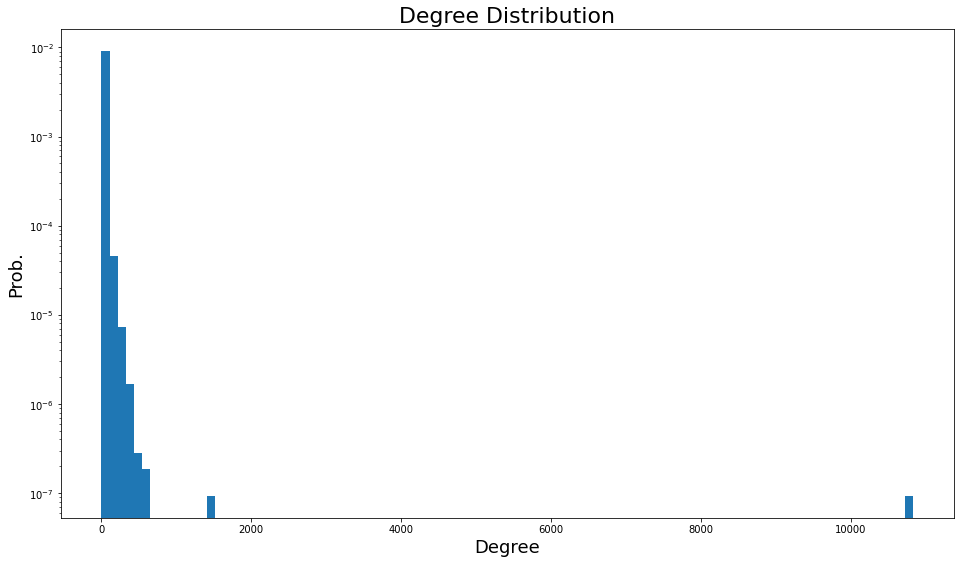

In [82]:
plot_degree_dist(G)

## Dictionary of nodes

In [33]:
'''
key=node
value=names
d_nodes={node1:name, node2:name,....}
'''
d_nodes={}
for n in tqdm(tot_nodes):
    d_nodes[n]=df_names.iloc[n].names

100%|██████████████████████████████████| 98343/98343 [00:18<00:00, 5284.40it/s]


In [72]:
len(d_nodes)

98343

In [ ]:
with open('nodes_name.pkl', 'wb') as handle:
    pickle.dump(d_nodes, handle)

In [ ]:
with open('nodes_name.pkl', 'rb') as handle:
    d_nodes = pickle.load(handle)

## Dictionary of edges

In [89]:
'''
key= node
value= list of tuples which represents out and in edges of that node
d_edges={node:[(edge1),(edge2)....]}
'''

d_edges=defaultdict(list)
for v in tqdm(df.values):
    d_edges[v[0]].append(tuple(v))
    d_edges[v[1]].append(tuple(v))

100%|██████████████████████████████| 483094/483094 [00:04<00:00, 110289.12it/s]


In [90]:
d_edges[108]

[(108, 1059989), (108, 1062426), (108, 1161925)]

In [91]:
len(d_edges)

98343

In [92]:
with open('edges.pkl', 'wb') as handle:
    pickle.dump(d_edges, handle)

In [ ]:
with open('edges.pkl', 'rb') as handle:
    d_edges = pickle.load(handle)

In [126]:
'''
key= node
value= list of tuples which represents out edges of that node
d_edges={node:[(edge1),(edge2)....]}
'''

d_edges_out=defaultdict(list)
for v in tqdm(df.values):
    d_edges_out[v[0]].append(tuple(v))

100%|██████████████████████████████| 483094/483094 [00:02<00:00, 232243.43it/s]


In [127]:
'''
key= node
value= list of tuples which represents in edges of that node
d_edges={node:[(edge1),(edge2)....]}
'''

d_edges_in=defaultdict(list)
for v in tqdm(df.values):
    d_edges_in[v[1]].append(tuple(v))

100%|██████████████████████████████| 483094/483094 [00:02<00:00, 214220.11it/s]


## Dictionary of degrees

In [144]:
'''
degree_nodes={node1:(total_degree,out_degree,in_degree)...}
'''
degree_nodes=defaultdict(list)
for n in tqdm(d_nodes):
    degree_nodes[n].append((len(d_edges[n]),len(d_edges_out[n]),len(d_edges_in[n])))

100%|█████████████████████████████████| 98343/98343 [00:01<00:00, 64188.88it/s]


Esempi

In [117]:
d_edges[1185516]#insieme degli archi incidenti su 1185516

[(95, 1185516),
 (1185516, 150451),
 (1185516, 1062563),
 (1185516, 1178930),
 (1185516, 1184017),
 (1185516, 1184695),
 (1185516, 1761109),
 (1198096, 1185516),
 (1230864, 1185516)]

In [129]:
d_edges_out[1185516] #insieme degli archi uscenti

[(1185516, 150451),
 (1185516, 1062563),
 (1185516, 1178930),
 (1185516, 1184017),
 (1185516, 1184695),
 (1185516, 1761109)]

In [128]:
d_edges_in[1185516]#insieme degli archi entranti

[(95, 1185516), (1198096, 1185516), (1230864, 1185516)]

In [145]:
degree_nodes[1185516]#grado totale,grado uscente,grado entrante

[(9, 6, 3)]

## Question 1

In [93]:
number_of_nodes=len(d_nodes)

In [149]:
number_of_edges=sum([len(d_edges[n]) for n in d_edges.keys()])/2

In [150]:
density = number_of_edges/(number_of_nodes*(number_of_nodes-1))

In [151]:
density

4.9951571365597335e-05

In [177]:
def plot_out_degree_dist(degree_nodes):
    degrees_out= [degree_nodes[n][0][1] for n in degree_nodes]
    plt.figure(figsize=(16,9))
    plt.title('Out Degree Distribution', size=22)
    plt.ylabel('Prob.', size=18)
    plt.xlabel('Out Degree', size=18)
    plt.hist(degrees_out, 100, log=True, density=True)
    plt.show()
    print('Average out degree : ',statistics.mean(degrees_out))

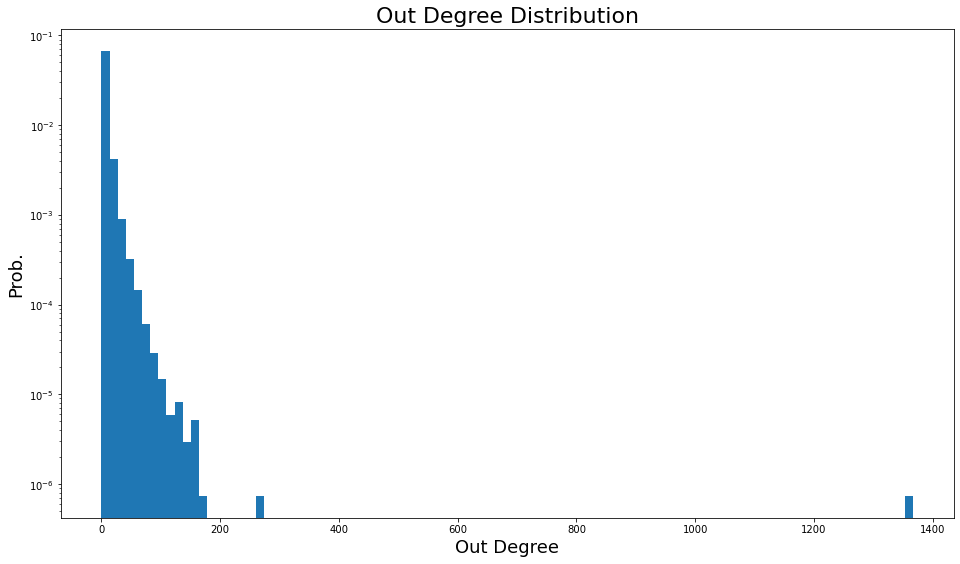

Average out degree :  4.912337431235573


In [178]:
plot_out_degree_dist(degree_nodes)

In [179]:
def plot_in_degree_dist(degree_nodes):
    degrees_in= [degree_nodes[n][0][2] for n in degree_nodes]
    plt.figure(figsize=(16,9))
    plt.title('Out Degree Distribution', size=22)
    plt.ylabel('Prob.', size=18)
    plt.xlabel('Out Degree', size=18)
    plt.hist(degrees_in, 100, log=True, density=True)
    plt.show()
    print('Average in degree : ',statistics.mean(degrees_in))
    

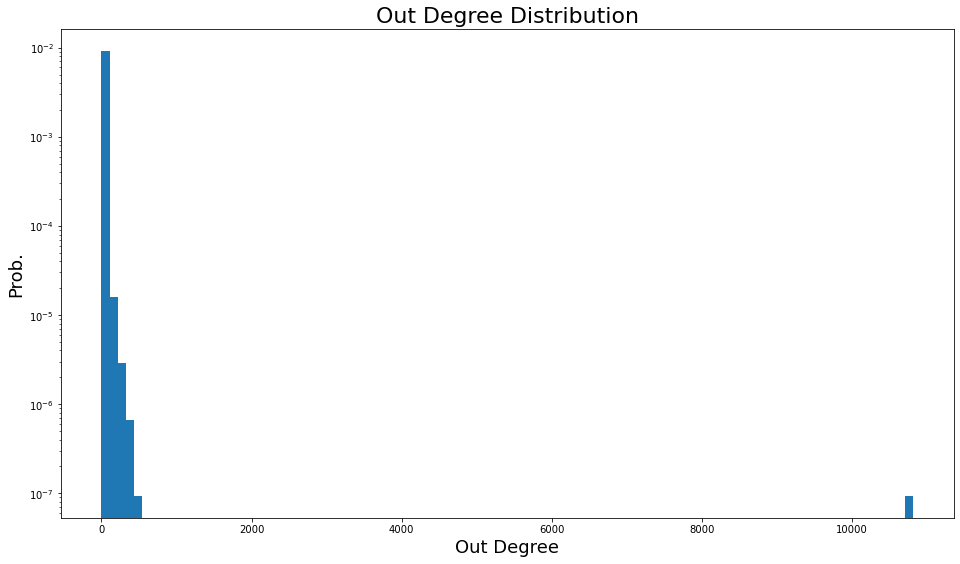

Average in degree :  4.912337431235573


In [180]:
plot_in_degree_dist(degree_nodes)

## Question 2

In [ ]:
def breadth_first_search(start,steps):
    for i in range(steps):
        print('nodi a distanza ',i)
        
        for n in d_edges_out[start]:
            print
    